In [ ]:
!pip install osmnx geopandas folium

In [53]:
import osmnx as ox
import networkx as nx

In [54]:
G_osmnx = ox.graph_from_place("Lisboa, Portugal", network_type='drive')
G_osmnx = G_osmnx.to_undirected()


In [55]:
# coordenadas de início e fim
start_coords = (38.70616277991234, -9.145214164271783)
end_coords = (38.758396748040894, -9.153133859419391)

# obter nós mais próximos às coordenadas
orig_node = ox.distance.nearest_nodes(G_osmnx, X=start_coords[1], Y=start_coords[0])
dest_node = ox.distance.nearest_nodes(G_osmnx, X=end_coords[1], Y=end_coords[0])

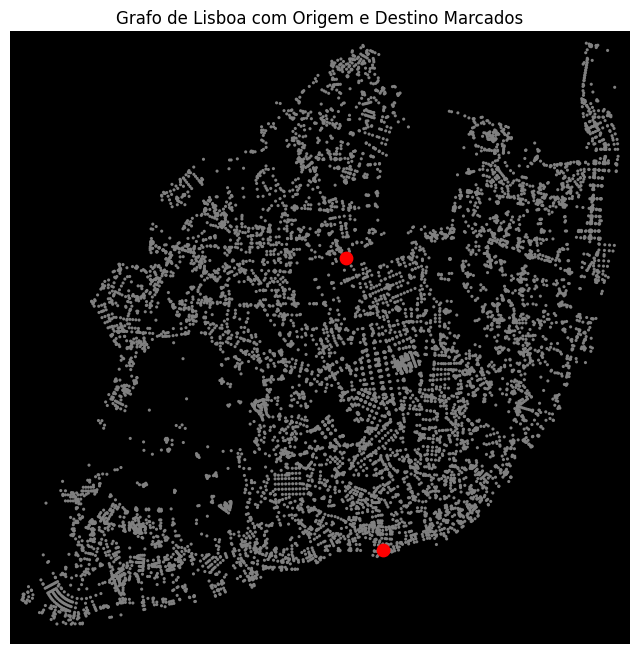

In [56]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(
    G_osmnx,
    node_size=5,
    node_color="gray",
    edge_color="black",
    bgcolor="black",
    show=False,
    close=False
)

# destacar origem e destino em vermelho
nx.draw_networkx_nodes(
    G_osmnx,
    pos={orig_node: (G_osmnx.nodes[orig_node]['x'], G_osmnx.nodes[orig_node]['y']),
         dest_node: (G_osmnx.nodes[dest_node]['x'], G_osmnx.nodes[dest_node]['y'])},
    nodelist=[orig_node, dest_node],
    node_color='red',
    node_size=80,
    ax=ax
)

plt.title("Grafo de Lisboa com Origem e Destino Marcados")
plt.show()


In [57]:
# converter G_osmnx para um grafo estilo dicionário
map_graph = {}
for u, v, data in G_osmnx.edges(data=True):
    weight = data.get("length", 1) # teste com 'travel_time' se quiser depois :D
    map_graph.setdefault(u, []).append((v, weight))
    map_graph.setdefault(v, []).append((u, weight))

note que o grafo contém:

```
21270962: [
    (11407374456, 379.43),
    (245930205, 187.95),
    (5162987186, 111.69)
]
```

o formato que criamos:

```
{
    node_1: [(vizinho_1, peso_1), (vizinho_2, peso_2)],
    node_2: [(vizinho_3, peso_3)],
    ...
}
```

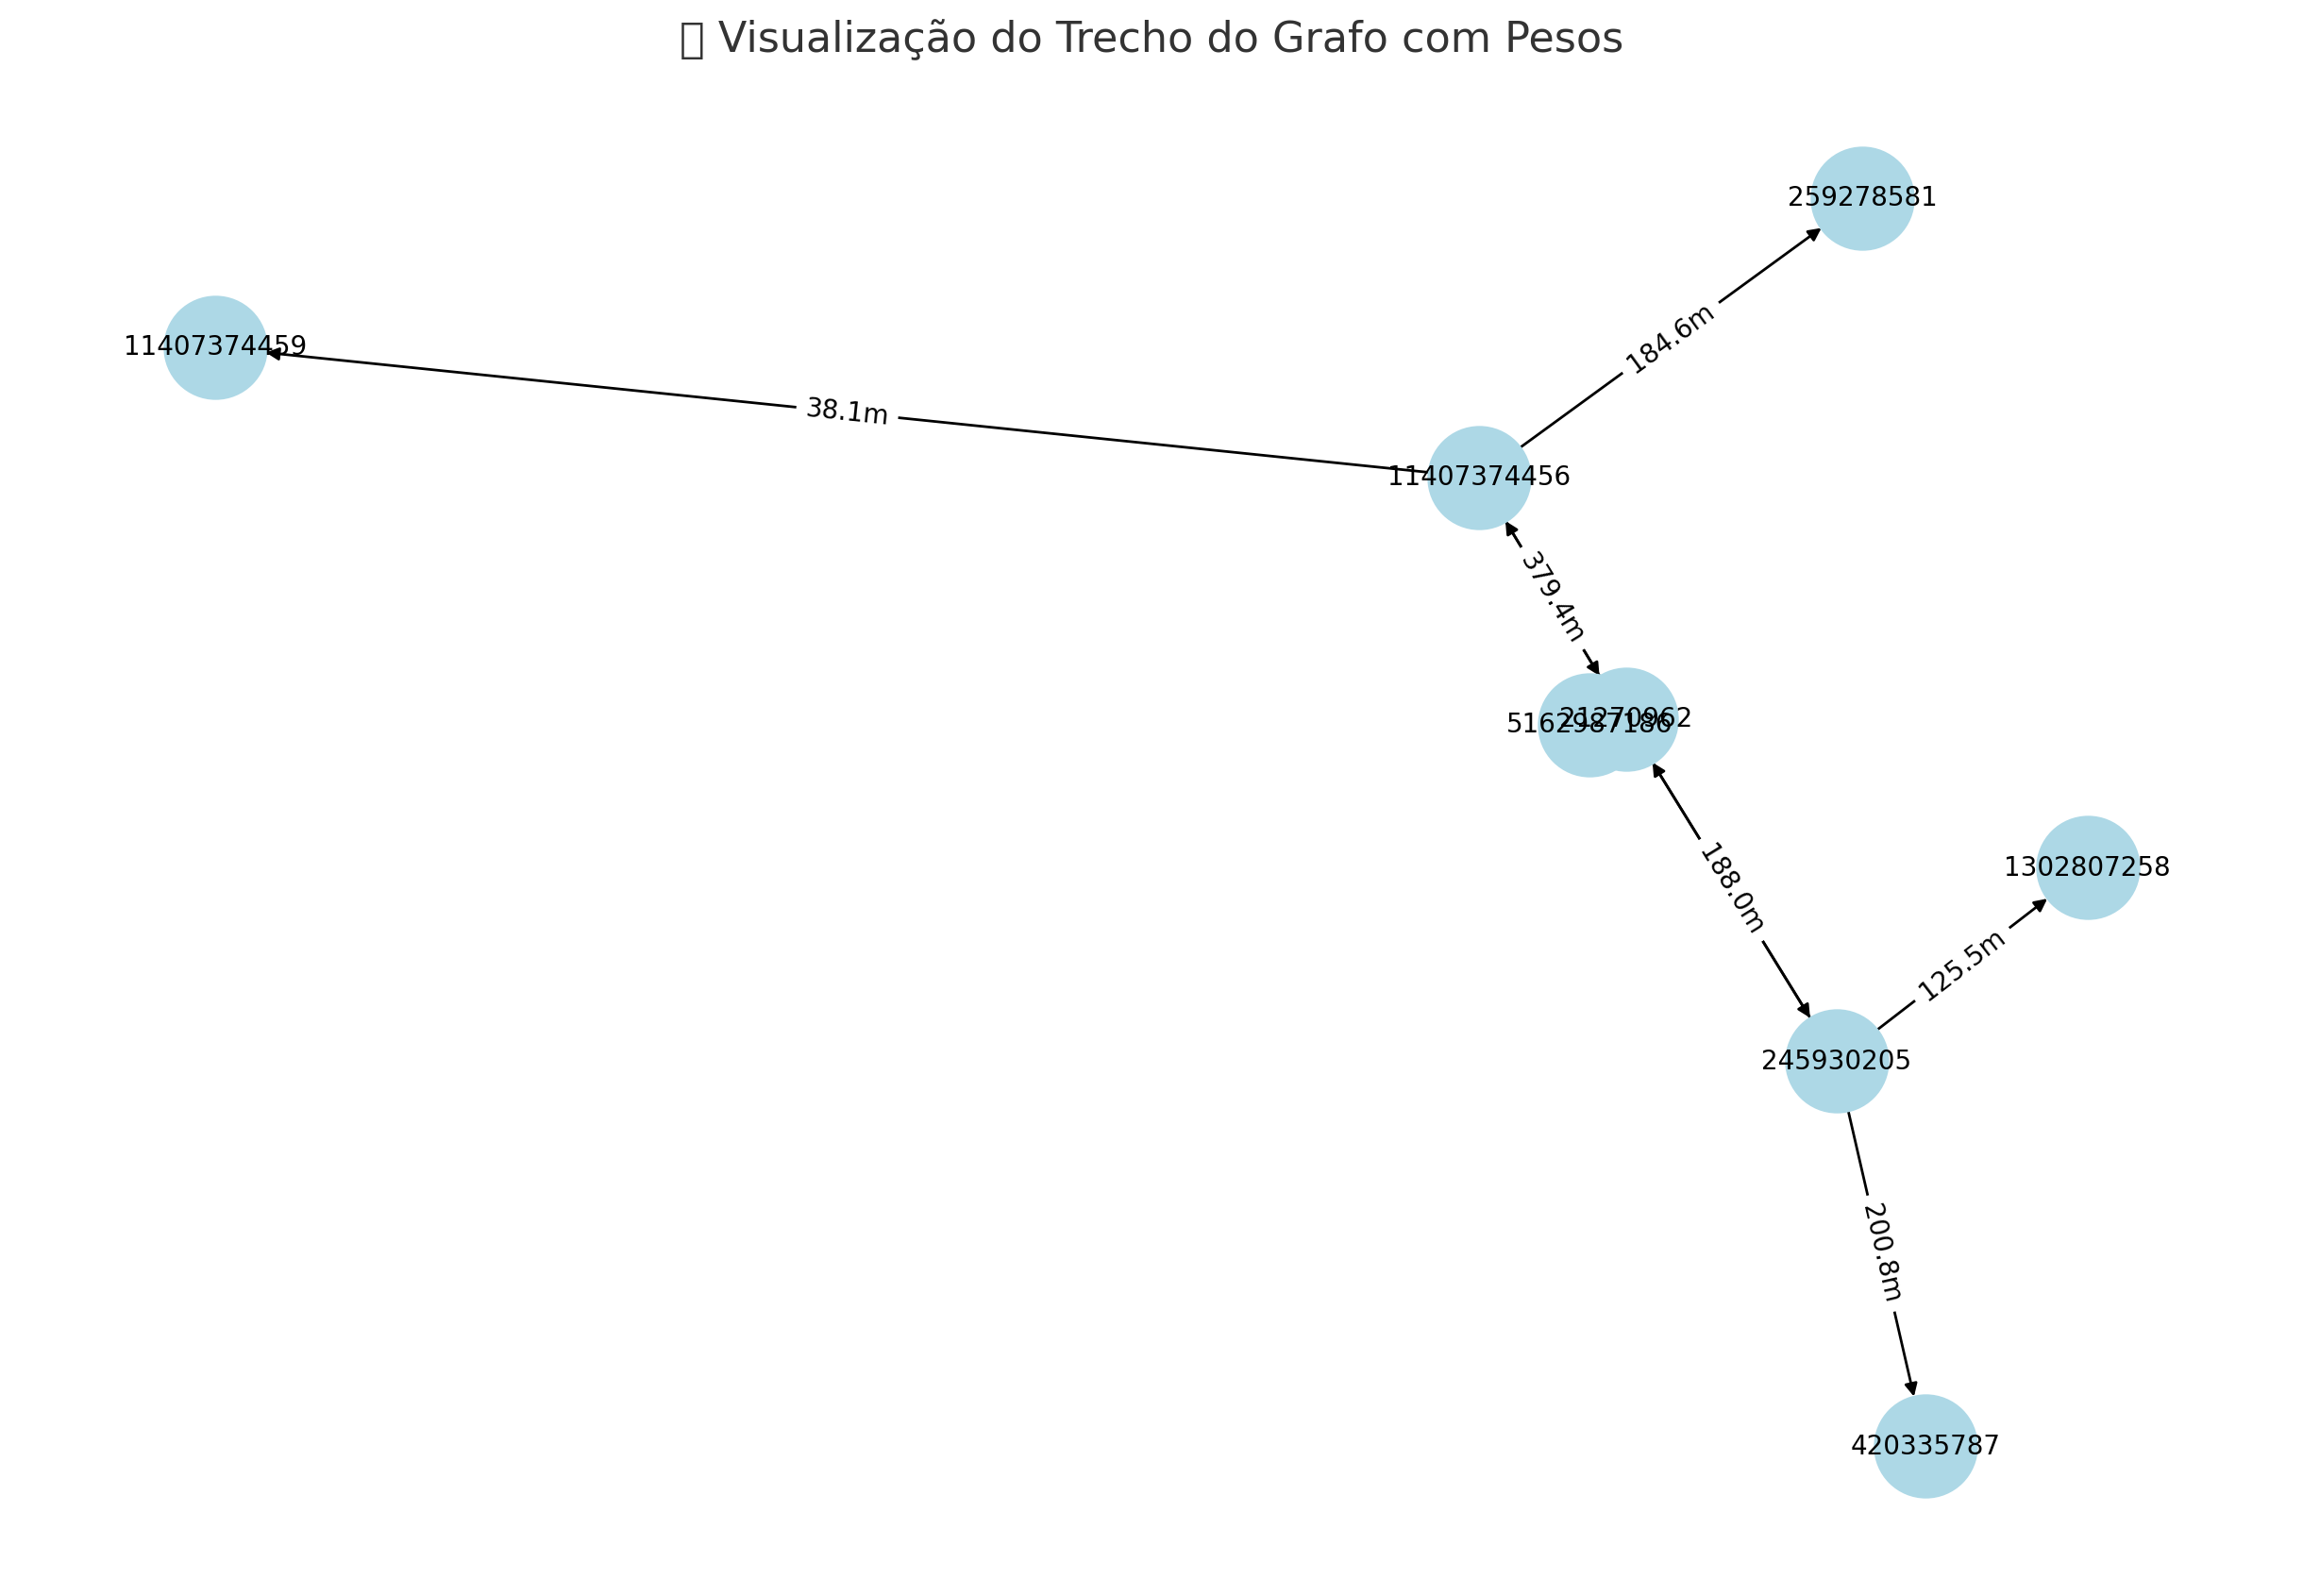

In [ ]:
from collections import defaultdict
import heapq

def dijkstra(graph, start):
    # sua implementação vai aqui

    return dist, parent

# Executar com nós reais
distances, parents = dijkstra(map_graph, orig_node)

# Reconstruir caminho
def show_path(parents, goal):
    path = []
    while goal is not None:
        path.insert(0, goal)
        goal = parents.get(goal)
    return path

shortest_path = show_path(parents, dest_node)


In [ ]:
shortest_path

In [ ]:
print("Nós de origem e destino:")
print("Origem:", orig_node)
print("Destino:", dest_node)

print("\nCaminho mais curto encontrado:")
print(shortest_path)

print("\nNúmero de nós no caminho:", len(shortest_path))
print("Destino está no caminho?", dest_node in shortest_path)

# Verifique se há nós inválidos
missing_nodes = [n for n in shortest_path if n not in G_osmnx.nodes]
print("Nós inválidos no caminho:", missing_nodes)


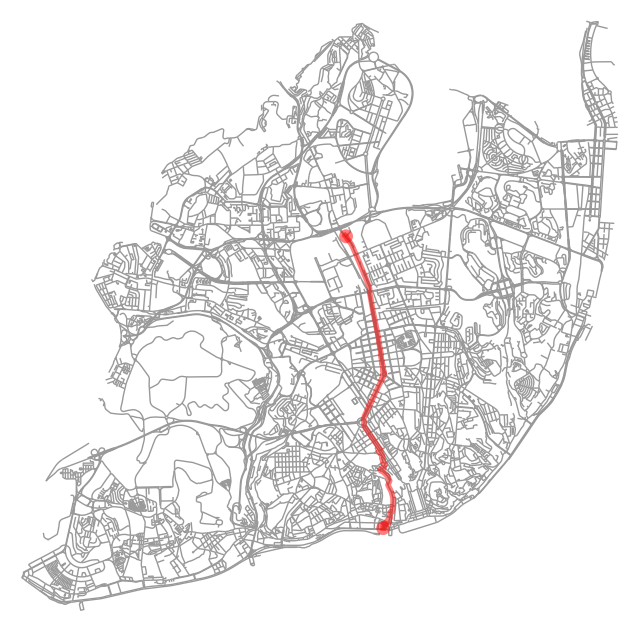

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [62]:
ox.plot_graph_route(G_osmnx, shortest_path, route_linewidth=4, node_size=0, bgcolor='white')

# Vejamos a propagação do algoritmo

In [ ]:
def dijkstra(graph, start):
    # sua implementação aqui

    return dist, parent, visited_edges


In [64]:
# Dijkstra com arestas visitadas
distances, parents, visited_edges = dijkstra(map_graph, orig_node)
shortest_path = show_path(parents, dest_node)
shortest_edges = list(zip(shortest_path[:-1], shortest_path[1:]))


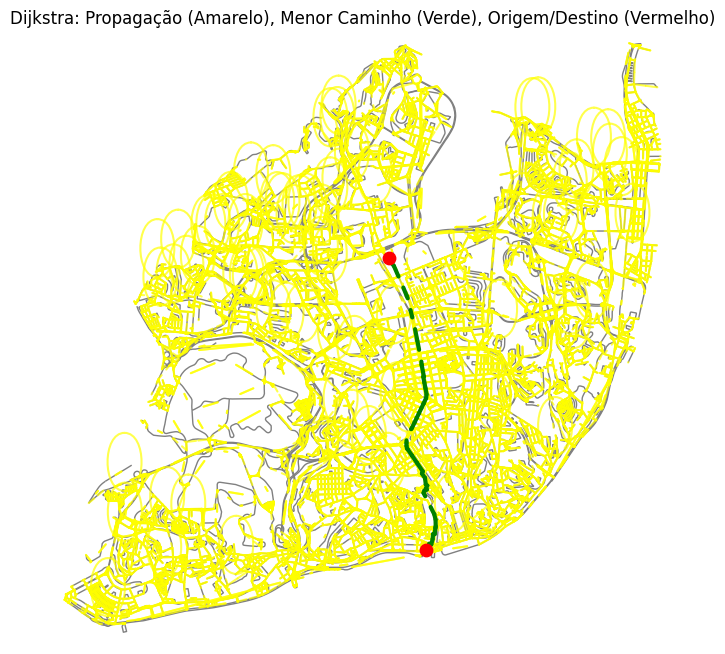

In [65]:
fig, ax = ox.plot_graph(
    G_osmnx,
    node_size=0,
    edge_color="gray",
    bgcolor="white",
    show=False,
    close=False
)

# Desenhar as arestas exploradas em amarelo
nx.draw_networkx_edges(
    G_osmnx,
    pos={n: (G_osmnx.nodes[n]['x'], G_osmnx.nodes[n]['y']) for n in G_osmnx.nodes},
    edgelist=visited_edges,
    edge_color='yellow',
    width=1.5,
    alpha=0.7,
    ax=ax
)

# Desenhar o menor caminho em verde/azul
nx.draw_networkx_edges(
    G_osmnx,
    pos={n: (G_osmnx.nodes[n]['x'], G_osmnx.nodes[n]['y']) for n in G_osmnx.nodes},
    edgelist=shortest_edges,
    edge_color='green',
    width=3,
    ax=ax
)

# Destacar origem e destino
nx.draw_networkx_nodes(
    G_osmnx,
    pos={
        orig_node: (G_osmnx.nodes[orig_node]['x'], G_osmnx.nodes[orig_node]['y']),
        dest_node: (G_osmnx.nodes[dest_node]['x'], G_osmnx.nodes[dest_node]['y'])
    },
    nodelist=[orig_node, dest_node],
    node_color='red',
    node_size=80,
    ax=ax
)

plt.title("Dijkstra: Propagação (Amarelo), Menor Caminho (Verde), Origem/Destino (Vermelho)")
plt.show()


# Vamos dar uma olhadinha no mapa :)

In [67]:
import geopandas as gpd
from shapely.geometry import LineString

# criar geometrias a partir do menor caminho
lines = [LineString([(G_osmnx.nodes[u]['x'], G_osmnx.nodes[u]['y']),
                     (G_osmnx.nodes[v]['x'], G_osmnx.nodes[v]['y'])]) for u, v in shortest_edges]

# criar GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=lines)
gdf.set_crs(epsg=4326, inplace=True)

# exportar para GeoJSON
gdf.to_file("shortest_path.geojson", driver='GeoJSON')



In [68]:
import folium
m = folium.Map(location=start_coords, zoom_start=13)

# adicionar rota
folium.PolyLine([(G_osmnx.nodes[n]['y'], G_osmnx.nodes[n]['x']) for n in shortest_path],
                color="green", weight=5, opacity=0.8).add_to(m)

# marcar origem e destino
folium.Marker(start_coords, popup="Origem", icon=folium.Icon(color='red')).add_to(m)
folium.Marker(end_coords, popup="Destino", icon=folium.Icon(color='red')).add_to(m)

m.save("rota_interativa.html")
m
